# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve
from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
def analise_bi (data, x:str, y:str):
    tab = (pd.crosstab(df[x], df[y], margins= True)
           .assign(media_doentes = lambda x: (x[1]/x['All']))
           .assign(odds = lambda x: x[1]/x[0])
           .assign(OR_vs_All = lambda x: x['odds']/x.loc['All','odds'])
           .assign(logito = lambda x: np.log(x['odds']))
           .assign(WOE = lambda x: np.log(x['OR_vs_All'])))

    return tab

In [5]:
analise_bi(df,'cp','flag_doente')

flag_doente,0,1,All,media_doentes,odds,OR_vs_All,logito,WOE
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [6]:
analise_bi(df,'ca','flag_doente')

flag_doente,0,1,All,media_doentes,odds,OR_vs_All,logito,WOE
ca,,,,,,,,
0.0,130,46,176,0.261364,0.353846,0.417488,-1.038893,-0.873501
1.0,21,44,65,0.676923,2.095238,2.472079,0.739667,0.905060
2.0,7,31,38,0.815789,4.428571,5.225077,1.488077,1.653470
3.0,3,17,20,0.850000,5.666667,6.685851,1.734601,1.899994
?,3,1,4,0.250000,0.333333,0.393285,-1.098612,-0.933220
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [7]:
analise_bi(df,'exang','flag_doente')

flag_doente,0,1,All,media_doentes,odds,OR_vs_All,logito,WOE
exang,,,,,,,,
0.0,141,63,204,0.308824,0.446809,0.527170,-0.805625,-0.640233
1.0,23,76,99,0.767677,3.304348,3.898655,1.195239,1.360632
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


- A variável `cp` parace discriminar mais o risco.

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [8]:
def analise_bi_cat (data, x:str, y:str):
    categorias = pd.qcut(df[x], 5)
    group_reg = df.groupby(categorias)
    tab = (pd.crosstab(categorias, df[y], margins=True)
           .assign(media_doentes = lambda x: (x[1]/x['All']))
           .assign(odds = lambda x: x[1]/x[0])
           .assign(OR_vs_All = lambda x: x['odds']/x.loc['All','odds'])
           .assign(logito = lambda x: np.log(x['odds']))
           .assign(WOE = lambda x: np.log(x['OR_vs_All'])))
    tab['media_'+x] = (group_reg[x].mean())
    
    return tab

In [9]:
analise_bi_cat(df,'trestbps','flag_doente')

flag_doente,0,1,All,media_doentes,odds,OR_vs_All,logito,WOE,media_trestbps
trestbps,,,,,,,,,
"(93.999, 120.0]",60,37,97,0.381443,0.616667,0.727578,-0.483427,-0.318034,113.463918
"(120.0, 126.0]",10,15,25,0.600000,1.500000,1.769784,0.405465,0.570858,124.320000
"(126.0, 134.0]",35,27,62,0.435484,0.771429,0.910175,-0.259511,-0.094119,130.177419
"(134.0, 144.6]",34,24,58,0.413793,0.705882,0.832840,-0.348307,-0.182914,139.103448
"(144.6, 200.0]",25,36,61,0.590164,1.440000,1.698993,0.364643,0.530036,158.180328
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,NaN


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [10]:
reglog = smf.logit(" flag_doente ~ C(sex) + C(cp) + trestbps + age"
                   , data=df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                  0.3097
Time:                        10:18:07   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(sex)[T.1.0]     1.8094      0.353      5.130      0.000       1.118       2.501
C(cp)[T.2.0]     -0.0617      0.636     -0.097      0.923      -1.309       1.186
C(cp)[T.3.0]      0.0715      0.573      0.125      0.901      -1.051       1.194
C(cp)[T.4.0]      2.4789      0.553      4.485      0.000       1.396       3.562
trestbps          0.0193      0.009      2.261      0.024       0.003       0.036
age               0.0567      0.018      3.120      0.002       0.021       0.092
=================================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [11]:
df['predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.027278


In [12]:
qualid = analise_bi_cat(df,'predito','flag_doente')
qualid

flag_doente,0,1,All,media_doentes,odds,OR_vs_All,logito,WOE,media_predito
predito,,,,,,,,,
"(0.0131, 0.143]",57,5,62,0.080645,0.087719,0.103496,-2.433613,-2.268221,0.072008
"(0.143, 0.287]",50,9,59,0.152542,0.180000,0.212374,-1.714798,-1.549406,0.209626
"(0.287, 0.586]",32,30,62,0.483871,0.937500,1.106115,-0.064539,0.100854,0.435175
"(0.586, 0.822]",14,45,59,0.762712,3.214286,3.792395,1.167605,1.332998,0.708861
"(0.822, 0.944]",11,50,61,0.819672,4.545455,5.362982,1.514128,1.679520,0.874819
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,NaN


Text(0.5, 0, 'Grupo')

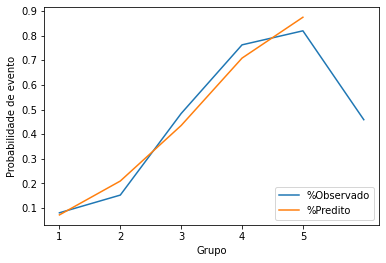

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['media_doentes'].plot(label='%Observado')
ax = qualid['media_predito'].plot(label='%Predito')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')


5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

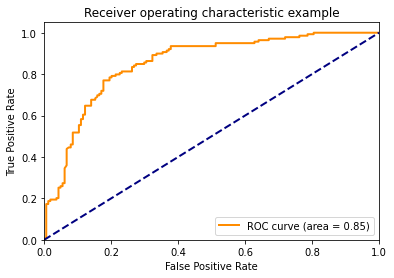

In [15]:
# Curva ROC:
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

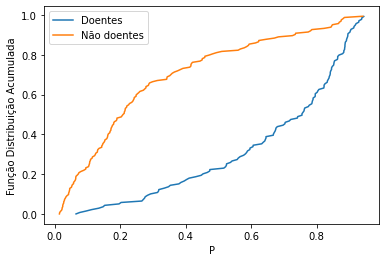

In [16]:
# Gráfico KS:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Doentes')

score_pop2 = df.loc[df['flag_doente']!=1,'predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Não doentes')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')


In [17]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 79.54%
KS: 59.30% 
AUC: 85.19% 
GINI: 70.39%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [18]:
# Manter somente C(cp)[T.4.0] no modelo:
df2 = df.copy()
df2['cp'] = df2['cp'].replace([1, 2, 3], 0)
df2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,1.0,0.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.886566
3,37.0,1.0,0.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.134929
4,41.0,0.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.027278


In [19]:
reglog = smf.logit(" flag_doente ~ C(sex) + C(cp) + C(exang) + thalach + C(ca) + trestbps"
                   , data=df2).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.370719
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                  0.4625
Time:                        10:18:59   Log-Likelihood:                -112.33
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 8.284e-37
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.8353      1.867     -1.519      0.129      -6.494       0.823
C(sex)[T.1.0]       1.7950      0.399      4.501      0.000       1.013       2.577
C(cp)[T.4.0]        1.8340      0.370      4.955      0.000       1.109       2.559
C(exang)[T.1.0]     1.0504      0.401      2.622      0.009       0.265       1.836
C(ca)[T.1.0]        1.8034      0.432      4.174      0.000       0.957       2.650
C(ca)[T.2.0]        2.6355      0.576      4.579      0.000       1.507       3.764
C(ca)[T.3.0]        2.2348      0.741      3.017      0.003       0.783       3.687
C(ca)[T.?]         -0.3642      1.540     -0.236      0.813      -3.383       2.655
thalach            -0.0292      0.009     -3.189      0.001      -0.047      -0.011
trestbps            0.0283      0.010      2.948      0.003       0.009       0.047
===================================================================================
"""

In [20]:
df2['predito'] = reglog.predict(df2)
df2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,1.0,0.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.209927
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.995708
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.983720
3,37.0,1.0,0.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.055622
4,41.0,0.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.014947


In [21]:
qualid = analise_bi_cat(df2,'predito','flag_doente')
qualid

flag_doente,0,1,All,media_doentes,odds,OR_vs_All,logito,WOE,media_predito
predito,,,,,,,,,
"(0.0131, 0.143]",57,5,62,0.080645,0.087719,0.103496,-2.433613,-2.268221,0.072008
"(0.143, 0.287]",50,9,59,0.152542,0.180000,0.212374,-1.714798,-1.549406,0.209626
"(0.287, 0.586]",32,30,62,0.483871,0.937500,1.106115,-0.064539,0.100854,0.435175
"(0.586, 0.822]",14,45,59,0.762712,3.214286,3.792395,1.167605,1.332998,0.708861
"(0.822, 0.944]",11,50,61,0.819672,4.545455,5.362982,1.514128,1.679520,0.874819
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,NaN


Text(0.5, 0, 'Grupo')

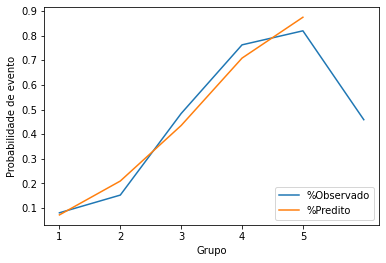

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['media_doentes'].plot(label='%Observado')
ax = qualid['media_predito'].plot(label='%Predito')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')


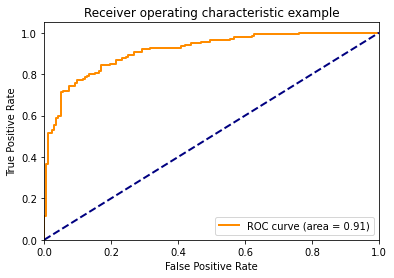

In [23]:
# Curva ROC:
fpr, tpr, thresholds = metrics.roc_curve(df2['flag_doente'], df2['predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df2['flag_doente'], df2['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

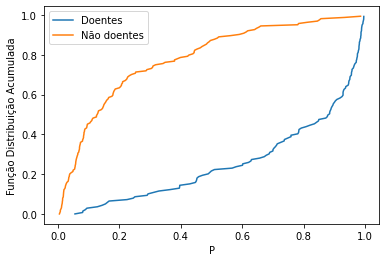

In [24]:
# Gráfico KS:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df2.loc[df2['flag_doente']==1,'predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Doentes')

score_pop2 = df2.loc[df2['flag_doente']!=1,'predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Não doentes')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')


In [25]:
acc = metrics.accuracy_score(df2['flag_doente'], df2['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df2['flag_doente'], df2['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df2.loc[df2['flag_doente'] == 1, 'predito'], df2.loc[df2['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 83.17%
KS: 67.22% 
AUC: 91.27% 
GINI: 82.54%


Queria tirar a variável `C(ca)[T.?]` do modelo mas não soube como.

De qualquer forma, houve melhora na acurácia do modelo.